# Python Flight Mechanics Engine 

## Aircraft 

In [37]:
import pyfme
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from pyfme.aircrafts import SimplifiedCessna172, Cessna172

In [43]:
aircraft = SimplifiedCessna172()

In [44]:
aircraft.full_state

AttributeError: 'SimplifiedCessna172' object has no attribute 'full_state'

Aircraft will provide the simulator the forces, moments and inertial properties in order to perform the integration of the dynamic system equations:

In [45]:
print(f"Aircraft mass: {aircraft.mass} kg")
print(f"Aircraft inertia tensor: \n {aircraft.inertia} kg/m²")

Aircraft mass: 1043.2616 kg
Aircraft inertia tensor: 
 [[ 1285.3154166      0.             0.        ]
 [    0.          1824.9309607      0.        ]
 [    0.             0.          2666.89390765]] kg/m²


In [46]:
print(f"forces: {aircraft.total_forces} N")
print(f"moments: {aircraft.total_moments} N·m")

forces: [ 0.  0.  0.] N
moments: [ 0.  0.  0.] N·m


In [47]:
print("Stability Derivatives : ")
for k,val in aircraft.__dict__.items():
    if k.startswith('C') and "data" not in k and "_" in k:
        print(f"{k} = {val};")

Stability Derivatives : 
CL_0 = 0.148;
CM_0 = 0.012068670774609398;
CL_alpha = 5.44;
CL_q = 7.281999999999999;
CL_delta_elev = 0.005677366997294861;
CM_alpha2 = -0.0008829539354397849;
CM_alpha = -0.01230758597735665;
CM_q = -12.464;
CM_delta_elev = -0.014180595130748421;
CD_K1 = 0.04394233763124108;
CD_0 = 0.029537580994030695;
CL_MAX = 1.889;
CY_beta = -0.26799999999999996;
CY_p = -0.05993333333333333;
CY_r = 0.2143333333333333;
CY_delta_rud = -0.561;
Cl_beta = -0.022292500000000003;
Cl_p = -0.3025083333333333;
Cl_r_cl = 0.17341925931518656;
Cl_delta_rud = -0.0027193749999999996;
Cl_delta_aile = 0.0044410237288135595;
CN_beta = 0.0126;
CN_p_al = -0.007206294994140298;
CN_r_cl = -0.00957535593543321;
CN_r_0 = -0.027354917660317425;
CN_delta_rud = 0.016818749999999997;
CN_delta_aile_cl = -0.0004745447361550377;
Ct_J2 = -0.16921210379223448;
Ct_J = 0.03545196433877688;
C_0 = 0.10446359303931643;


For the aircraft, in order to calculate its forces and moments it is necessary to set the controls values within the limits: 

In [ ]:
print(aircraft.controls)

In [ ]:
print(aircraft.control_limits)

but also to provide and environment (ie. atmosphere, winds, gravity) and the aircraft state, which will also determine the aerodynamic contribution.

## Environment 

In [ ]:
from pyfme.environment.atmosphere import ISA1976
from pyfme.environment.wind import NoWind
from pyfme.environment.gravity import VerticalConstant

In [ ]:
atmosphere = ISA1976()
gravity = VerticalConstant()
wind = NoWind()

The atmosphere, wind and gravity model make up the environment:

In [ ]:
from pyfme.environment import Environment

In [ ]:
environment = Environment(atmosphere, gravity, wind)

The environment has an update method which given the state (ie. position, altitude...) updates the environment variables (ie. density, wind magnitude, gravity force...)

In [ ]:
help(environment.update)

## State 

Even if the state can be set manually by giving the position, attitude, velocity, angular velocities... Most of the times, the user will want to trim the aircraft in a stationary condition. The aircraft controls to flight in that condition will be also provided by the trimmer.

In [ ]:
from pyfme.utils.trimmer import steady_state_trim

In [ ]:
help(steady_state_trim)

In [ ]:
from pyfme.models.state.position import EarthPosition

In [ ]:
pos = EarthPosition(x=0, y=0, height=1000)
psi = 0.5  # rad
TAS = 45  # m/s
controls0 = {'delta_elevator': 0, 'delta_aileron': 0, 'delta_rudder': 0, 'delta_t': 0.5}

In [ ]:
trimmed_state, trimmed_controls = steady_state_trim(
    aircraft,
    environment,
    pos,
    psi,
    TAS,
    controls0
)    

In [ ]:
trimmed_state

In [ ]:
trimmed_controls

Now, all the necessary elements in order to calculate forces and moments are available 

In [ ]:
# Environment conditions for the current state:
environment.update(trimmed_state)

# Forces and moments calculation:
forces, moments = aircraft.calculate_forces_and_moments(trimmed_state, environment, controls0)

In [ ]:
print("NDIM forces : ")
for k,val in aircraft.__dict__.items():
    if k.startswith('C') and "data" not in k and "_" not in k:
        print(f"{k} : {val}")

In [ ]:
forces, moments

The aircraft is trimmed indeed: the total forces and moments (aerodynamics + gravity + thrust) are zero

## Simulation 

In order to simulate the dynamics of the aircraft under certain inputs in an environment, the user can set up a simulation using a dynamic system:

In [739]:
from pyfme.models import EulerFlatEarth

In [740]:
system = EulerFlatEarth(t0=0, full_state=trimmed_state)

### Constant Controls 

Let's set the controls for the aircraft during the simulation. As a first step we will set them constant and equal to the trimmed values.

In [741]:
from pyfme.utils.input_generator import Constant

In [742]:
controls = {
    'delta_elevator': Constant(trimmed_controls['delta_elevator']),
    'delta_aileron': Constant(trimmed_controls['delta_aileron']),
    'delta_rudder': Constant(trimmed_controls['delta_rudder']),
    'delta_t': Constant(trimmed_controls['delta_t'])
}

In [743]:
from pyfme.simulator import Simulation

In [744]:
sim = Simulation(aircraft, system, environment, controls)

In [745]:
system = EulerFlatEarth(t0=0, full_state=trimmed_state)
sim = Simulation(aircraft, system, environment, controls)

Once the simulation is set, the propagation can be performed:

In [767]:
results = sim.propagate(5)



time: 10.0it [00:00, ?it/s]



The results are returned in a DataFrame:

In [747]:
results

,Fx,Fy,Fz,Mach,Mx,My,Mz,TAS,a,aileron,...,thrust,u,v,v_down,v_east,v_north,w,x_earth,y_earth,z_earth
time,,,,,,,,,,,,,,,,,,,,,
0.01,1.546141e-11,1.688011e-16,0.000000e+00,0.133756,-3.667941e-13,-1.355845e-11,-1.585097e-14,45.0,336.434581,-9.644866e-18,...,0.577997,44.87164,-3.511938e-15,4.440892e-16,21.574149,39.491215,3.396464,0.394912,0.215741,-1000.0
0.02,1.546141e-11,5.250914e-17,0.000000e+00,0.133756,-3.506913e-13,-1.314636e-11,-1.347614e-14,45.0,336.434581,-9.644866e-18,...,0.577997,44.87164,-3.512042e-15,4.440892e-16,21.574149,39.491215,3.396464,0.789824,0.431483,-1000.0
0.03,1.546141e-11,-3.441253e-16,0.000000e+00,0.133756,-3.352723e-13,-1.274679e-11,-1.121474e-14,45.0,336.434581,-9.644866e-18,...,0.577997,44.87164,-3.512218e-15,4.440892e-16,21.574149,39.491215,3.396464,1.184736,0.647224,-1000.0
0.04,1.546141e-11,-1.008065e-15,0.000000e+00,0.133756,-3.205078e-13,-1.235936e-11,-9.062203e-15,45.0,336.434581,-9.644866e-18,...,0.577997,44.87164,-3.512470e-15,4.440892e-16,21.574149,39.491215,3.396464,1.579649,0.862966,-1000.0
0.05,1.546141e-11,-1.926832e-15,0.000000e+00,0.133756,-3.063696e-13,-1.198371e-11,-7.014180e-15,45.0,336.434581,-9.644866e-18,...,0.577997,44.87164,-3.512798e-15,4.440892e-16,21.574149,39.491215,3.396464,1.974561,1.078707,-1000.0
0.06,1.546141e-11,-3.088483e-15,0.000000e+00,0.133756,-2.928307e-13,-1.161948e-11,-5.066498e-15,45.0,336.434581,-9.644866e-18,...,0.577997,44.87164,-3.513206e-15,4.440892e-16,21.574149,39.491215,3.396464,2.369473,1.294449,-1000.0
0.07,1.534772e-11,-4.481585e-15,1.818989e-12,0.133756,-2.798654e-13,-1.126632e-11,-3.215162e-15,45.0,336.434581,-9.644866e-18,...,0.577997,44.87164,-3.513695e-15,4.440892e-16,21.574149,39.491215,3.396464,2.764385,1.510190,-1000.0
0.08,1.534772e-11,-6.095197e-15,1.818989e-12,0.133756,-2.674490e-13,-1.092389e-11,-1.456347e-15,45.0,336.434581,-9.644866e-18,...,0.577997,44.87164,-3.514266e-15,4.440892e-16,21.574149,39.491215,3.396464,3.159297,1.725932,-1000.0
0.09,1.534772e-11,-7.918846e-15,1.818989e-12,0.133756,-2.555579e-13,-1.059187e-11,2.136113e-16,45.0,336.434581,-9.644866e-18,...,0.577997,44.87164,-3.514923e-15,0.000000e+00,21.574149,39.491215,3.396464,3.554209,1.941673,-1000.0


In [28]:
%matplotlib inline

In [749]:
kwargs = {'marker': '.',
          'subplots': True,
          'sharex': True,
          'figsize': (12, 6)}

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


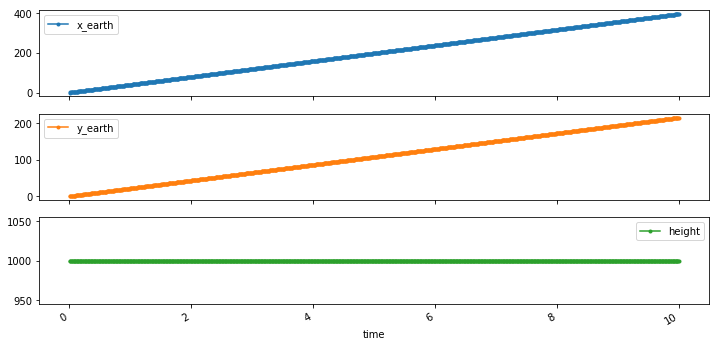

In [750]:
results.plot(y=['x_earth', 'y_earth', 'height'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


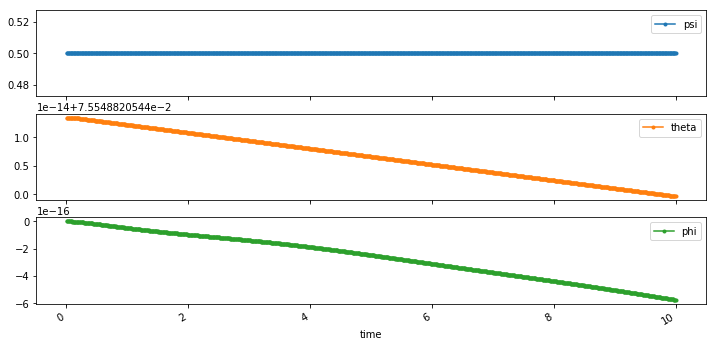

In [751]:
results.plot(y=['psi', 'theta', 'phi'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


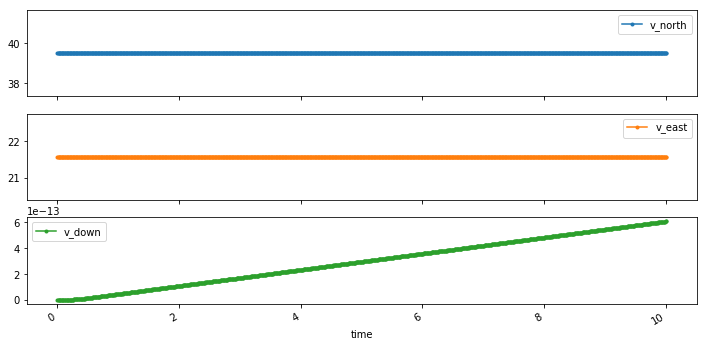

In [752]:
results.plot(y=['v_north', 'v_east', 'v_down'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


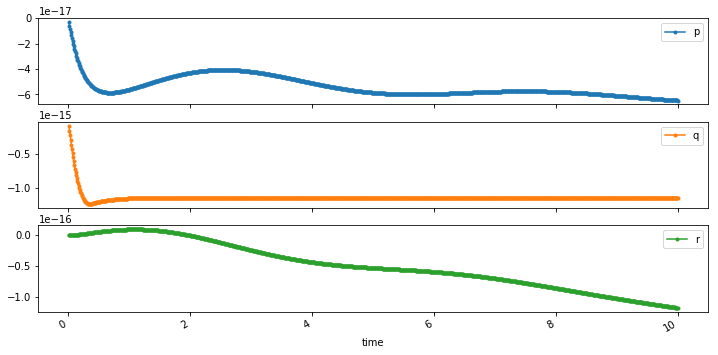

In [753]:
results.plot(y=['p', 'q', 'r'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


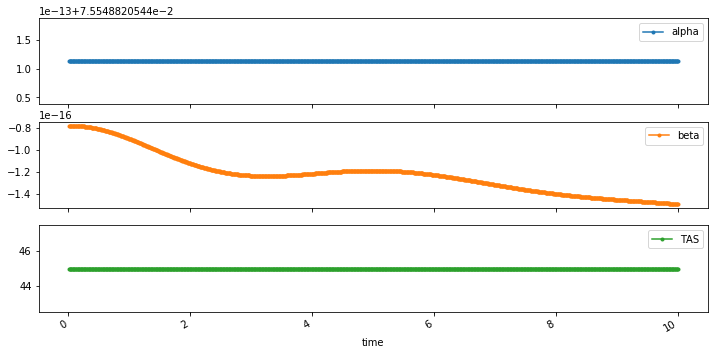

In [754]:
results.plot(y=['alpha', 'beta', 'TAS'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


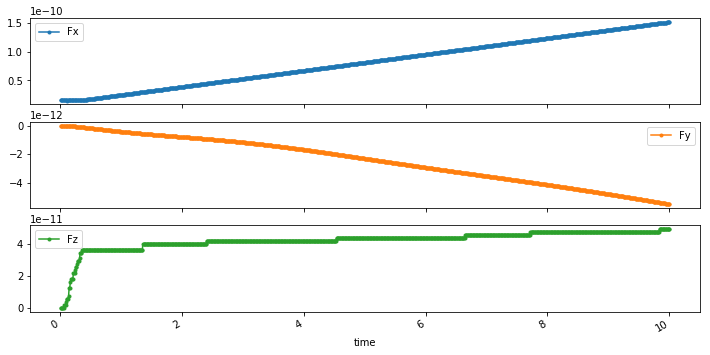

In [757]:
results.plot(y=['Fx', 'Fy', 'Fz'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


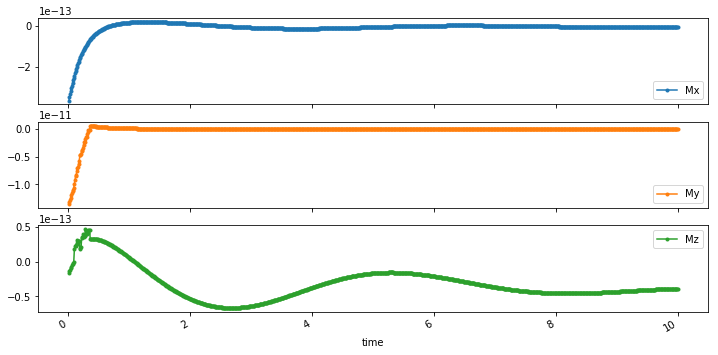

In [756]:
results.plot(y=['Mx', 'My', 'Mz'], **kwargs);

In [159]:
aircraft.CM_0

0.0075

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


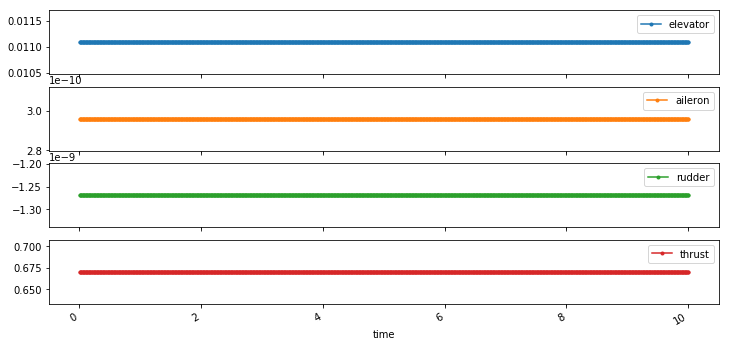

In [60]:
results.plot(y=['elevator', 'aileron', 'rudder', 'thrust'], **kwargs);

### Doublet 

Let's set the controls for the aircraft during the simulation. As a first step we will set them constant and equal to the trimmed values.

In [291]:
from pyfme.utils.input_generator import Doublet

In [292]:
de0 = trimmed_controls['delta_elevator']

In [293]:
controls = controls = {
    'delta_elevator': Doublet(t_init=2, T=1, A=0.1, offset=de0),
    'delta_aileron': Constant(trimmed_controls['delta_aileron']),
    'delta_rudder': Constant(trimmed_controls['delta_rudder']),
    'delta_t': Constant(trimmed_controls['delta_t'])
}

In [294]:
sim = Simulation(aircraft, system, environment, controls)

Once the simulation is set, the propagation can be performed:

In [295]:
results = sim.propagate(90)


time:   0%|                                                                                     | 0/90 [00:00<?, ?it/s]
time:   0%|                                                           | 0.19000000000000003/90 [00:00<00:53,  1.69it/s]
time:   0%|▎                                                           | 0.4000000000000002/90 [00:00<00:51,  1.74it/s]
time:   1%|▎                                                           | 0.5400000000000003/90 [00:00<00:55,  1.60it/s]
time:   1%|▍                                                           | 0.7200000000000004/90 [00:00<00:56,  1.59it/s]
time:   1%|▋                                                           | 0.9400000000000006/90 [00:00<00:53,  1.68it/s]
time:   1%|▊                                                           | 1.1400000000000008/90 [00:00<00:50,  1.76it/s]
time:   2%|▉                                                            | 1.360000000000001/90 [00:00<00:49,  1.80it/s]
time:   2%|█                           

time:  27%|█████████████████                                              | 24.300000000001/90 [00:15<00:45,  1.45it/s]
time:  27%|████████████████▎                                           | 24.470000000001026/90 [00:15<00:43,  1.51it/s]
time:  27%|████████████████▋                                            | 24.63000000000105/90 [00:15<00:46,  1.41it/s]
time:  28%|████████████████▌                                           | 24.780000000001074/90 [00:15<00:51,  1.27it/s]
time:  28%|████████████████▋                                           | 24.960000000001102/90 [00:16<00:46,  1.39it/s]
time:  28%|█████████████████                                            | 25.14000000000113/90 [00:16<00:45,  1.43it/s]
time:  28%|████████████████▊                                           | 25.310000000001157/90 [00:16<00:43,  1.47it/s]
time:  28%|████████████████▉                                           | 25.470000000001182/90 [00:16<00:43,  1.48it/s]
time:  28%|█████████████████            

time:  52%|███████████████████████████████▏                            | 46.809999999999256/90 [00:31<00:37,  1.15it/s]
time:  52%|███████████████████████████████▊                             | 46.94999999999923/90 [00:31<00:38,  1.12it/s]
time:  52%|████████████████████████████████▍                             | 47.0799999999992/90 [00:32<00:37,  1.13it/s]
time:  52%|███████████████████████████████▉                             | 47.20999999999918/90 [00:32<00:50,  1.19s/it]
time:  53%|███████████████████████████████▌                            | 47.319999999999155/90 [00:32<00:48,  1.13s/it]
time:  53%|████████████████████████████████▏                            | 47.42999999999913/90 [00:32<00:46,  1.10s/it]
time:  53%|████████████████████████████████▏                            | 47.52999999999911/90 [00:32<00:46,  1.10s/it]
time:  53%|████████████████████████████████▎                            | 47.62999999999909/90 [00:32<00:50,  1.19s/it]
time:  53%|█████████████████████████████

time:  84%|███████████████████████████████████████████████████          | 75.29000000000161/90 [00:46<00:06,  2.18it/s]
time:  84%|███████████████████████████████████████████████████▏         | 75.51000000000172/90 [00:46<00:06,  2.15it/s]
time:  84%|███████████████████████████████████████████████████▎         | 75.73000000000184/90 [00:47<00:06,  2.10it/s]
time:  84%|███████████████████████████████████████████████████▍         | 75.96000000000195/90 [00:47<00:06,  2.11it/s]
time:  85%|███████████████████████████████████████████████████▋         | 76.18000000000207/90 [00:47<00:06,  2.08it/s]
time:  85%|███████████████████████████████████████████████████▊         | 76.39000000000217/90 [00:47<00:06,  2.06it/s]
time:  85%|███████████████████████████████████████████████████▉         | 76.60000000000228/90 [00:47<00:08,  1.62it/s]
time:  85%|████████████████████████████████████████████████████         | 76.78000000000237/90 [00:47<00:07,  1.66it/s]
time:  86%|█████████████████████████████

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


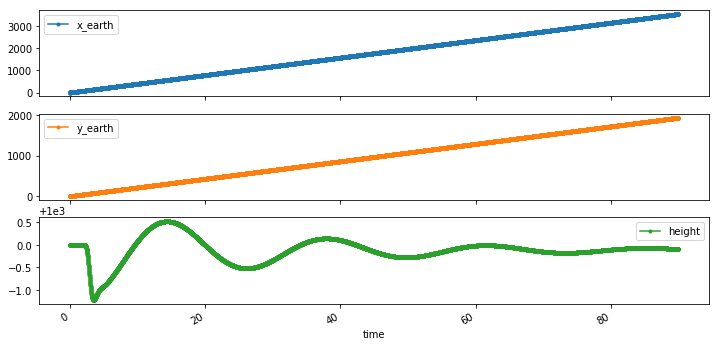

In [296]:
results.plot(y=['x_earth', 'y_earth', 'height'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


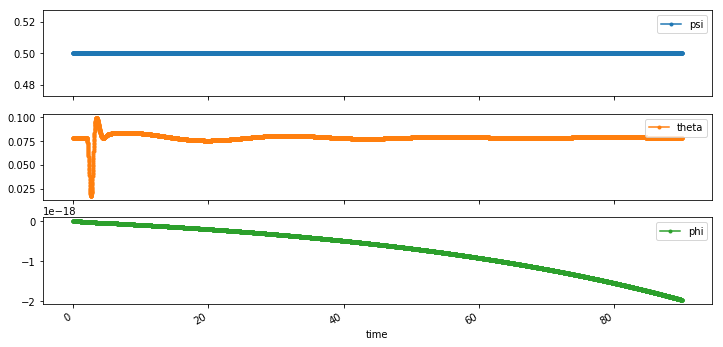

In [297]:
results.plot(y=['psi', 'theta', 'phi'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


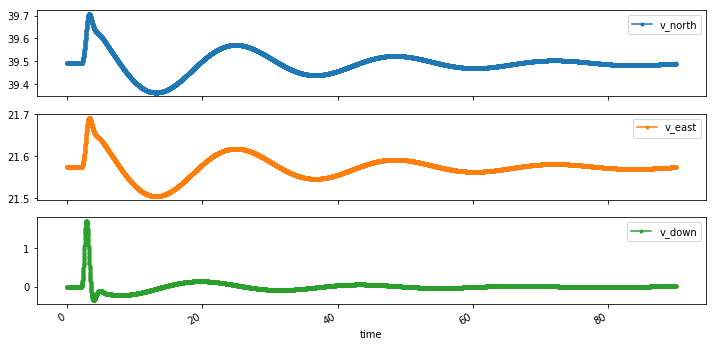

In [298]:
results.plot(y=['v_north', 'v_east', 'v_down'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


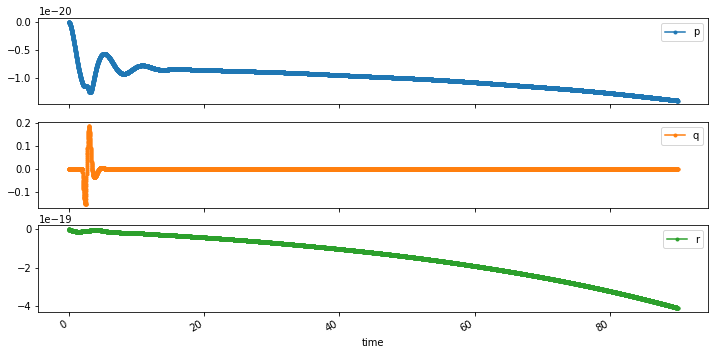

In [299]:
results.plot(y=['p', 'q', 'r'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


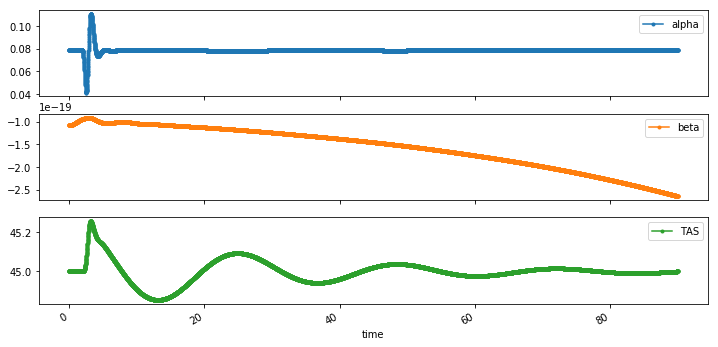

In [300]:
results.plot(y=['alpha', 'beta', 'TAS'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


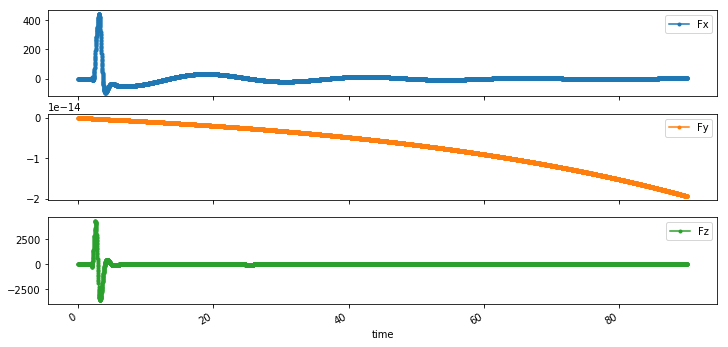

In [301]:
results.plot(y=['Fx', 'Fy', 'Fz'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


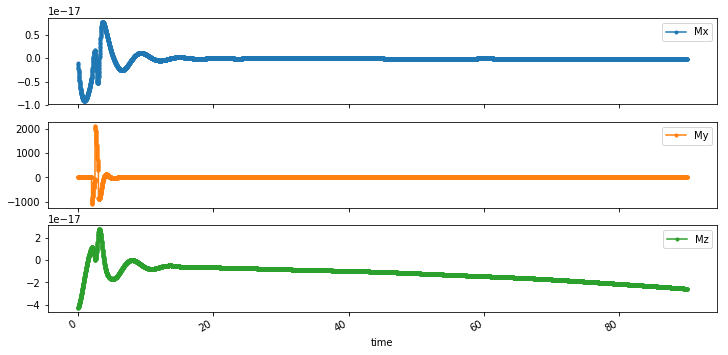

In [302]:
results.plot(y=['Mx', 'My', 'Mz'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


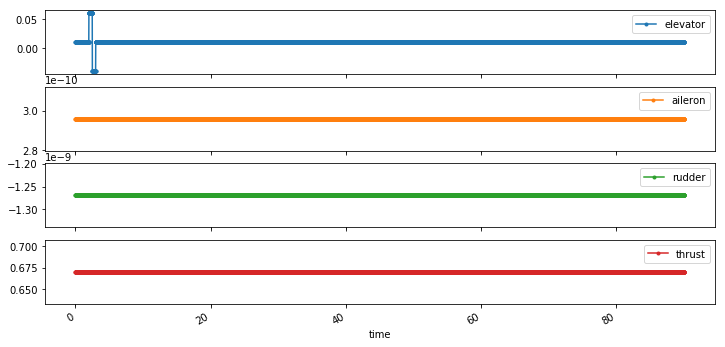

In [73]:
results.plot(y=['elevator', 'aileron', 'rudder', 'thrust'], **kwargs);

## Propagating only one time step

In [74]:
dt = 0.05  # seconds
sim = Simulation(aircraft, system, environment, controls, dt)

In [75]:
results = sim.propagate(0.5)
results

time: 100%|█████████████████████████████████████████████████████████▉| 0.49999999999999994/0.5 [00:05<00:00, 11.52s/it]


,Fx,Fy,Fz,Mach,Mx,My,Mz,TAS,a,aileron,...,thrust,u,v,v_down,v_east,v_north,w,x_earth,y_earth,z_earth
time,,,,,,,,,,,,,,,,,,,,,
0.05,-2860.288296,-0.000007,-23948.338630,0.133444,3.670972e-06,416.026942,-0.000001,44.895162,336.434581,2.959742e-10,...,0.670198,44.877493,1.089215e-07,-0.021778,21.523885,39.399206,-1.259451,1.972256,1.077449,-999.999987
0.10,-2841.450134,-0.000007,-23790.055374,0.133135,2.754411e-06,382.934882,-0.000001,44.791157,336.434574,2.959742e-10,...,0.670198,44.773564,1.085156e-07,-0.059100,21.474006,39.307904,-1.255270,3.939933,2.152395,-1000.001805
0.15,-2814.079427,-0.000007,-23634.534640,0.132827,2.070495e-06,344.981012,-0.000001,44.687646,336.434555,2.959742e-10,...,0.670198,44.670646,1.080774e-07,-0.101132,21.424344,39.216999,-1.232525,5.903055,3.224853,-1000.006526
0.20,-2834.053374,-0.000006,-23475.855214,0.132523,1.564206e-06,331.492749,-0.000001,44.585409,336.434527,2.959742e-10,...,0.670198,44.567449,1.076118e-07,-0.219729,21.375124,39.126902,-1.265389,7.861673,4.294852,-1000.013745
0.25,-2844.314793,-0.000006,-23317.511918,0.132216,1.181851e-06,311.810632,-0.000001,44.482035,336.434473,2.959742e-10,...,0.670198,44.463623,1.071279e-07,-0.339570,21.325202,39.035520,-1.279696,9.815738,5.362362,-1000.027650
0.30,-2847.104415,-0.000006,-23160.410509,0.131908,8.962216e-07,288.008616,-0.000001,44.378277,336.434397,2.959742e-10,...,0.670198,44.359858,1.066288e-07,-0.462223,21.274925,38.943489,-1.278443,11.765219,6.427369,-1000.047414
0.35,-2867.759612,-0.000005,-23001.499461,0.131599,6.829096e-07,273.089782,-0.000001,44.274258,336.434294,2.959742e-10,...,0.670198,44.255295,1.061187e-07,-0.620164,21.224128,38.850505,-1.295661,13.710083,7.489853,-1000.073815
0.40,-2883.231719,-0.000005,-22843.131464,0.131287,5.237487e-07,255.164441,-0.000001,44.169584,336.434162,2.959742e-10,...,0.670198,44.150414,1.056017e-07,-0.781931,21.172708,38.756382,-1.301203,15.650273,8.549783,-1000.107951
0.45,-2892.153236,-0.000005,-22685.668716,0.130975,4.056468e-07,234.048222,-0.000001,44.064366,336.434000,2.959742e-10,...,0.670198,44.045377,1.050805e-07,-0.944579,21.120728,38.661234,-1.293510,17.585742,9.607135,-1000.149658


We can propagate for one time step even once the simulation has been propagated before:

In [76]:
results = sim.propagate(sim.time+dt)
results

time: 100%|████████████████████████████████████████████████████████████████████████| 0.55/0.55 [00:00<00:00,  9.12s/it]


,Fx,Fy,Fz,Mach,Mx,My,Mz,TAS,a,aileron,...,thrust,u,v,v_down,v_east,v_north,w,x_earth,y_earth,z_earth
time,,,,,,,,,,,,,,,,,,,,,
0.05,-2860.288296,-0.000007,-23948.338630,0.133444,3.670972e-06,416.026942,-0.000001,44.895162,336.434581,2.959742e-10,...,0.670198,44.877493,1.089215e-07,-0.021778,21.523885,39.399206,-1.259451,1.972256,1.077449,-999.999987
0.10,-2841.450134,-0.000007,-23790.055374,0.133135,2.754411e-06,382.934882,-0.000001,44.791157,336.434574,2.959742e-10,...,0.670198,44.773564,1.085156e-07,-0.059100,21.474006,39.307904,-1.255270,3.939933,2.152395,-1000.001805
0.15,-2814.079427,-0.000007,-23634.534640,0.132827,2.070495e-06,344.981012,-0.000001,44.687646,336.434555,2.959742e-10,...,0.670198,44.670646,1.080774e-07,-0.101132,21.424344,39.216999,-1.232525,5.903055,3.224853,-1000.006526
0.20,-2834.053374,-0.000006,-23475.855214,0.132523,1.564206e-06,331.492749,-0.000001,44.585409,336.434527,2.959742e-10,...,0.670198,44.567449,1.076118e-07,-0.219729,21.375124,39.126902,-1.265389,7.861673,4.294852,-1000.013745
0.25,-2844.314793,-0.000006,-23317.511918,0.132216,1.181851e-06,311.810632,-0.000001,44.482035,336.434473,2.959742e-10,...,0.670198,44.463623,1.071279e-07,-0.339570,21.325202,39.035520,-1.279696,9.815738,5.362362,-1000.027650
0.30,-2847.104415,-0.000006,-23160.410509,0.131908,8.962216e-07,288.008616,-0.000001,44.378277,336.434397,2.959742e-10,...,0.670198,44.359858,1.066288e-07,-0.462223,21.274925,38.943489,-1.278443,11.765219,6.427369,-1000.047414
0.35,-2867.759612,-0.000005,-23001.499461,0.131599,6.829096e-07,273.089782,-0.000001,44.274258,336.434294,2.959742e-10,...,0.670198,44.255295,1.061187e-07,-0.620164,21.224128,38.850505,-1.295661,13.710083,7.489853,-1000.073815
0.40,-2883.231719,-0.000005,-22843.131464,0.131287,5.237487e-07,255.164441,-0.000001,44.169584,336.434162,2.959742e-10,...,0.670198,44.150414,1.056017e-07,-0.781931,21.172708,38.756382,-1.301203,15.650273,8.549783,-1000.107951
0.45,-2892.153236,-0.000005,-22685.668716,0.130975,4.056468e-07,234.048222,-0.000001,44.064366,336.434000,2.959742e-10,...,0.670198,44.045377,1.050805e-07,-0.944579,21.120728,38.661234,-1.293510,17.585742,9.607135,-1000.149658


Notice that `results` will include the previous timesteps as well as the last one. To get just the last one one can use pandas `loc` or `iloc`:

In [77]:
results.iloc[-1]  # last time step

Fx            -2.921788e+03
Fy            -3.761191e-06
Fz            -2.236733e+04
Mach           1.303405e-01
Mx             2.513504e-07
My             1.969358e+02
Mz            -1.203167e-06
TAS            4.385090e+01
a              3.364336e+02
aileron        2.959742e-10
alpha         -2.924362e-02
beta           2.372590e-09
elevator       1.108958e-02
height         1.000261e+03
p              6.386588e-10
phi            2.537379e-10
pressure       8.987343e+04
psi            5.000000e-01
q              9.152033e-02
q_inf          1.068779e+03
r              1.349505e-10
rho            1.111631e+00
rudder        -1.269086e-09
temperature    2.816493e+02
theta          6.638492e-04
thrust         6.701981e-01
u              4.383215e+01
v              1.040402e-07
v_down        -1.311274e+00
v_east         2.101384e+01
v_north        3.846558e+01
w             -1.282176e+00
x_earth        2.144217e+01
y_earth        1.171391e+01
z_earth       -1.000261e+03
Name: 0.55, dtype: f

In [78]:
results.loc[sim.time]  # results for current simulation time

Fx            -2.921788e+03
Fy            -3.761191e-06
Fz            -2.236733e+04
Mach           1.303405e-01
Mx             2.513504e-07
My             1.969358e+02
Mz            -1.203167e-06
TAS            4.385090e+01
a              3.364336e+02
aileron        2.959742e-10
alpha         -2.924362e-02
beta           2.372590e-09
elevator       1.108958e-02
height         1.000261e+03
p              6.386588e-10
phi            2.537379e-10
pressure       8.987343e+04
psi            5.000000e-01
q              9.152033e-02
q_inf          1.068779e+03
r              1.349505e-10
rho            1.111631e+00
rudder        -1.269086e-09
temperature    2.816493e+02
theta          6.638492e-04
thrust         6.701981e-01
u              4.383215e+01
v              1.040402e-07
v_down        -1.311274e+00
v_east         2.101384e+01
v_north        3.846558e+01
w             -1.282176e+00
x_earth        2.144217e+01
y_earth        1.171391e+01
z_earth       -1.000261e+03
Name: 0.55, dtype: f

# Test


In [984]:
a1 = Cessna172()
a2 = SimplifiedCessna172()
e1 = copy.deepcopy(environment)
e2 = copy.deepcopy(environment)

In [985]:
ts1, tc1 = steady_state_trim(
    a1,
    e1,
    pos,
    psi,
    TAS,
    controls0
)
e1.update(ts1)
ss1 = EulerFlatEarth(t0=0, full_state=ts1)
ts1, tc1

(Aircraft State 
 x_e: 0.00 m, y_e: 0.00 m, z_e: -1000.00 m 
 theta: 0.076 rad, phi: 0.000 rad, psi: 0.500 rad 
 u: 44.87 m/s, v: -0.00 m/s, w: 3.40 m/s 
 P: 0.00 rad/s, Q: 0.00 rad/s, R: 0.00 rad/s 
 u_dot: 0.00 m/s², v_dot: -0.00 m/s², w_dot: 0.00 m/s² 
 P_dot: -0.00 rad/s², Q_dot: 0.00 rad/s², R_dot: -0.00 rad/s² ,
 {'delta_aileron': -1.2190588362567532e-17,
  'delta_elevator': -0.048951124635254917,
  'delta_rudder': 7.1787477633953699e-17,
  'delta_t': 0.57799667845449421})

In [986]:
ts2, tc2 = steady_state_trim(
    a2,
    e2,
    pos,
    psi,
    TAS,
    controls0
)    
e2.update(ts2)
ss2 = EulerFlatEarth(t0=0, full_state=ts2)
tc2, ts2

({'delta_aileron': -3.9966019045688599e-19,
  'delta_elevator': -0.07729883009616384,
  'delta_rudder': 2.7133156470881973e-18,
  'delta_t': 0.57166075967430052},
 Aircraft State 
 x_e: 0.00 m, y_e: 0.00 m, z_e: -1000.00 m 
 theta: 0.080 rad, phi: 0.000 rad, psi: 0.500 rad 
 u: 44.86 m/s, v: -0.00 m/s, w: 3.59 m/s 
 P: 0.00 rad/s, Q: 0.00 rad/s, R: 0.00 rad/s 
 u_dot: 0.00 m/s², v_dot: -0.00 m/s², w_dot: 0.00 m/s² 
 P_dot: -0.00 rad/s², Q_dot: -0.00 rad/s², R_dot: -0.00 rad/s² )

In [971]:
c1 = {
    'delta_elevator': Constant(tc1['delta_elevator']),
    'delta_aileron': Constant(tc1['delta_aileron']),
    'delta_rudder': Constant(tc1['delta_rudder']),
    'delta_t': Constant(tc1['delta_t'])
}
c2 = {
    'delta_elevator': Constant(tc2['delta_elevator']),
    'delta_aileron': Constant(tc2['delta_aileron']),
    'delta_rudder': Constant(tc2['delta_rudder']),
    'delta_t': Constant(tc2['delta_t'])
}
s1 = Simulation(a1, ss1, e1, c1)
s2 = Simulation(a2, ss2, e2, c2)
                              # Doublet(t_init=3, T=1, A=0.1, offset=0),

In [711]:
s1 = Simulation(aircraft, ss1, e1, c1)

In [712]:
r1 = s1.propagate(5);
# r2 = s2.propagate(5);



time:   0%|                                                                                      | 0/5 [00:00<?, ?it/s]

time:   1%|▊                                                                          | 0.05/5 [00:00<00:10,  2.11s/it]

time:   3%|█▌                                                          | 0.12999999999999998/5 [00:00<00:09,  1.87s/it]

time:   4%|██▎                                                         | 0.19000000000000003/5 [00:00<00:08,  1.86s/it]

time:   6%|███▊                                                         | 0.3100000000000001/5 [00:00<00:07,  1.57s/it]

time:   8%|████▉                                                        | 0.4000000000000002/5 [00:00<00:06,  1.45s/it]

time:   9%|█████▋                                                      | 0.47000000000000025/5 [00:00<00:07,  1.56s/it]

time:  11%|██████▌                                                      | 0.5400000000000003/5 [00:00<00:06,  1.56s/it]

time:  12%|███████▍           

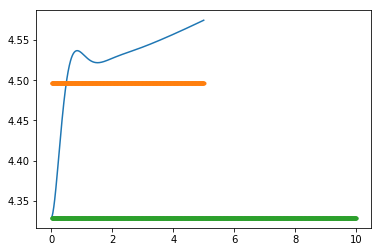

In [713]:
plt.plot(r1.alpha*180/np.pi)
plt.plot(r2.alpha*180/np.pi,'.')
plt.plot(results.alpha*180/np.pi,'.')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


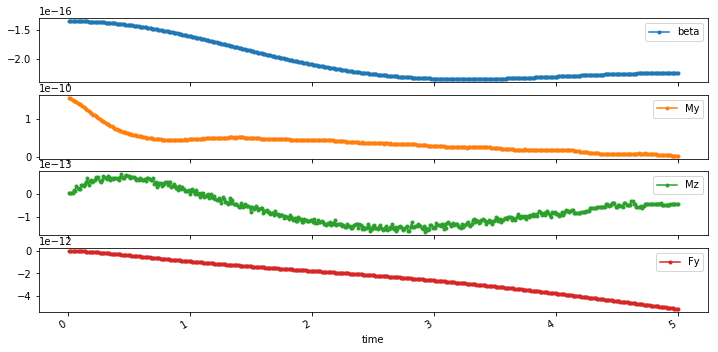

In [972]:
r1.plot(y=['beta', 'My', 'Mz', 'Fy'], **kwargs);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


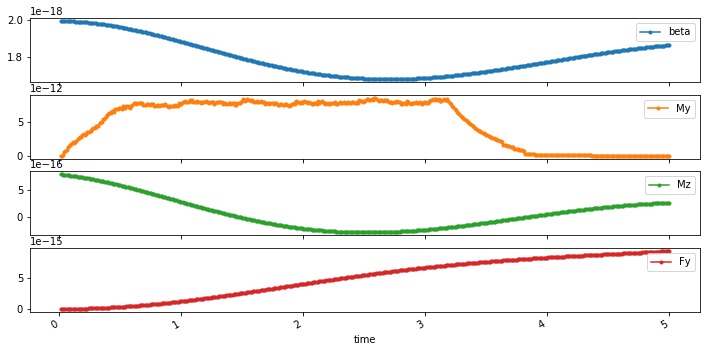

In [973]:
r2.plot(y=['beta', 'My', 'Mz', 'Fy'], **kwargs);

In [ ]:
plt.plot

ValueError: x and y must have same first dimension, but have shapes (12,) and (9, 12)

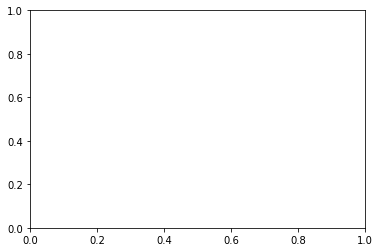

In [1111]:
plt.plot(a1.alpha_data, a1.CN_delta_aile_data, '.')
plt.plot(a1.alpha_data, a2.CN_delta_aile_cl*a2.CL + 0*a2.alpha_data)

In [1106]:
np.sum(a2.CL_data*a2.CN_p_data)/np.sum(a2.CL_data**2)

-0.069523541636556885

In [1119]:
x = np.reshape(a1.CL_data**2, (1, 12)) * np.reshape(a1.delta_aile_data, (9, 1))
np.sum(a1.CN_delta_aile_data*x) / np.sum(x**2)

-0.00027157871300302394

In [1120]:
linregress(x.flatten(), a1.CN_delta_aile_data.flatten())

LinregressResult(slope=-0.00027568577531501706, intercept=0.00072199122345927057, rvalue=-0.94235806962343571, pvalue=3.266896179580671e-52, stderr=9.5077855389690054e-06)

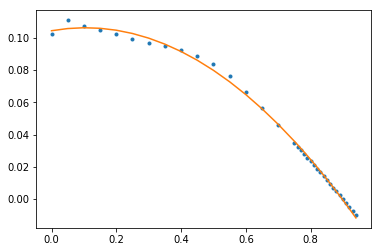

In [34]:
plt.plot(aircraft.J_data,aircraft.Ct_data,'.')
plt.plot(aircraft.J_data,-0.1692121*aircraft.J_data**2 +  0.03545196*aircraft.J_data  +0.10446359)

In [35]:
a,b,c = np.polyfit(aircraft.J_data,aircraft.Ct_data,2)